## Setup

In [2]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from catboost import CatBoostRegressor

## Load Dataset

In [4]:
train_raw = pd.read_csv("../../data/train_data.csv", parse_dates=["startdate"])
test_raw = pd.read_csv("../../data/test_data.csv", parse_dates=["startdate"])
submit = pd.read_csv("../../data/sample_solution.csv")
target = "contest-tmp2m-14d__tmp2m"

In [5]:
train_raw[target].describe()

count    375734.000000
mean         11.858568
std           9.867901
min         -20.358963
25%           4.818231
50%          12.285770
75%          19.441170
max          37.238782
Name: contest-tmp2m-14d__tmp2m, dtype: float64

In [6]:
# more information about the data
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375734 entries, 0 to 375733
Columns: 246 entries, index to wind-vwnd-925-2010-20
dtypes: datetime64[ns](1), float64(240), int64(4), object(1)
memory usage: 705.2+ MB


In [10]:
# check the missing value
print(train_raw.isnull().sum())
# find columns with missing value, and how many rows are missing
print(train_raw.isnull().sum()[train_raw.isnull().sum() > 0])

index                                 0
lat                                   0
lon                                   0
startdate                             0
contest-pevpr-sfc-gauss-14d__pevpr    0
                                     ..
wind-vwnd-925-2010-16                 0
wind-vwnd-925-2010-17                 0
wind-vwnd-925-2010-18                 0
wind-vwnd-925-2010-19                 0
wind-vwnd-925-2010-20                 0
Length: 246, dtype: int64
nmme0-tmp2m-34w__ccsm30    15934
nmme-tmp2m-56w__ccsm3      10280
nmme-prate-34w__ccsm3       8738
nmme0-prate-56w__ccsm30    15934
nmme0-prate-34w__ccsm30    15934
nmme-prate-56w__ccsm3      10280
nmme-tmp2m-34w__ccsm3       8738
ccsm30                     15934
dtype: int64


A pic from other people:
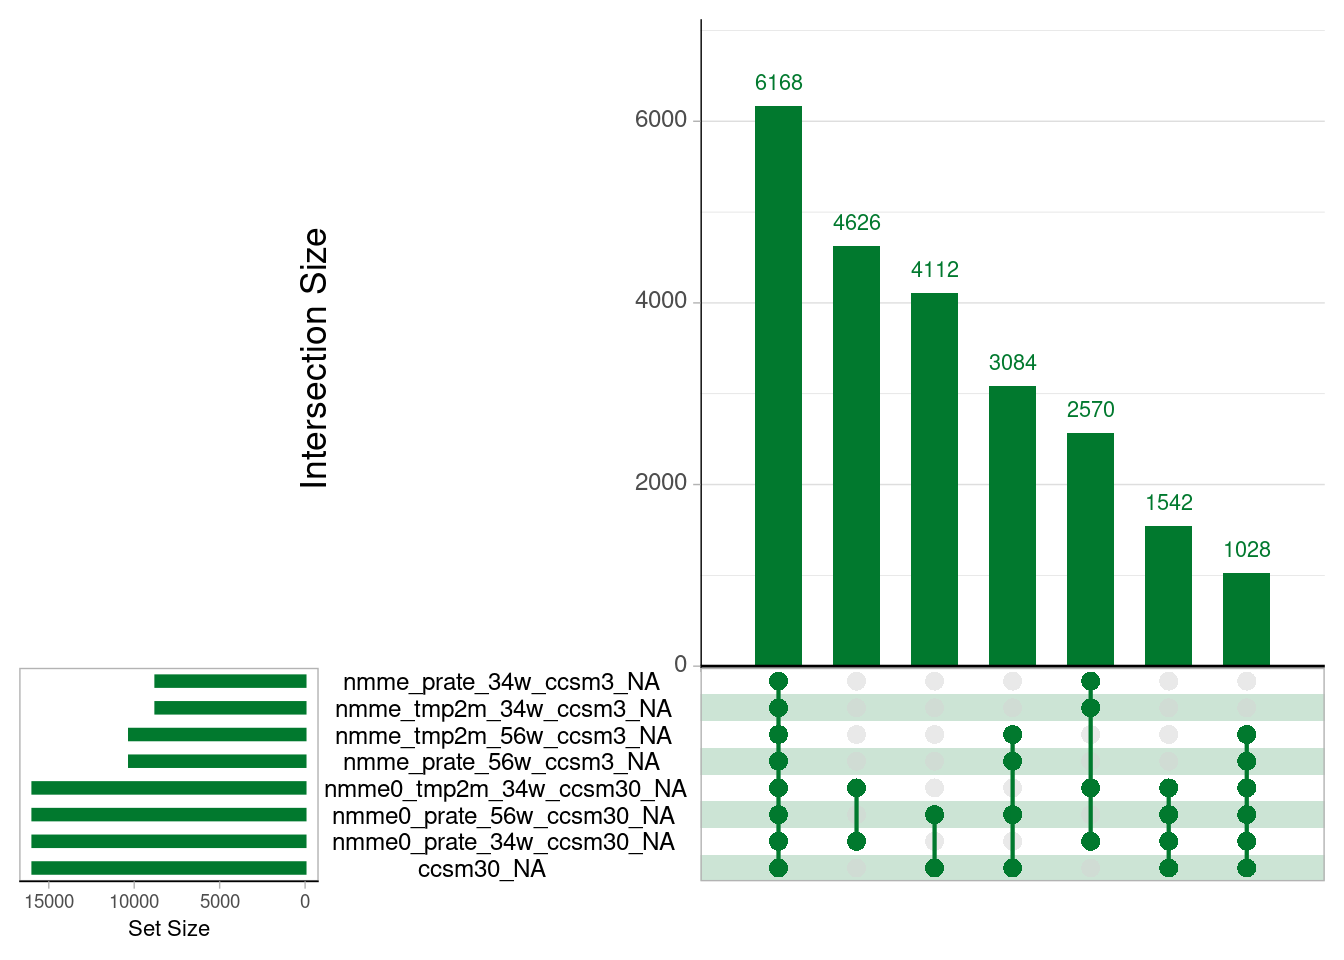

## Preprocessing

In [11]:
def location_nom(train, test):
    # Ref: https://www.kaggle.com/code/flaviafelicioni/wids-2023-different-locations-train-test-solved
    scale = 14

    train.loc[:,'lat']=round(train.lat,scale)
    train.loc[:,'lon']=round(train.lon,scale)
    test.loc[:,'lat']=round(test.lat,scale)
    test.loc[:,'lon']=round(test.lon,scale)

    all_df = pd.concat([train, test], axis=0)
    all_df['loc_group'] = all_df.groupby(['lat','lon']).ngroup()
    train = all_df.iloc[:len(train)]
    test = all_df.iloc[len(train):].drop(target, axis=1)
    
    return train, test

def categorical_encode(train, test):
    le = LabelEncoder()
    train['climateregions__climateregion'] = le.fit_transform(train['climateregions__climateregion'])
    test['climateregions__climateregion'] = le.transform(test['climateregions__climateregion'])
    return train, test
    
def fill_na(df):
    df = df.sort_values(by=['loc_group', 'startdate']).ffill()
    return df

def creat_new_featute(df):
    df['year'] = df['startdate'].dt.year
    df['month'] = df['startdate'].dt.month
    df['day_of_year'] = df['startdate'].dt.dayofyear
    # df['day_of_week'] = df['startdate'].dt.dayofweek
    # df['week_of_year'] = df['startdate'].dt.isocalendar().week
    return df

def feature_engineering(train_raw, test_raw):
    train, test = location_nom(train_raw, test_raw)
    train = fill_na(train)
    train = creat_new_featute(train)
    test = creat_new_featute(test)
    train, test = categorical_encode(train, test)

    drop_cols = ['index', 'startdate', 'lat', 'lon', target]
    features = [col for col in train.columns if col not in drop_cols]
    X = train[features]
    X_test = test[features]
    y = train[target]

    return X, y, X_test

## Train and Validation

In [12]:
def rmse(actual, predicted):
    return mean_squared_error(actual, predicted, squared=False)

In [14]:
X, y, X_test = feature_engineering(train_raw.copy(), test_raw.copy())
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.13, random_state=42)
print(f'Train_shape: {X_train.shape}    |   Val_shape: {X_val.shape}    |   Test_shape: {X_test.shape}')

Train_shape: (326888, 245)    |   Val_shape: (48846, 245)    |   Test_shape: (31354, 245)


In [18]:
model = CatBoostRegressor(verbose=200)

In [20]:

model.fit(X_train, y_train, eval_set=(X_val, y_val), early_stopping_rounds=200)
y_pred = model.predict(X_val)
print(f"RMSE for validation: {rmse(y_val, y_pred):.4f}")

Learning rate set to 0.126374
0:	learn: 8.7799360	test: 8.7733170	best: 8.7733170 (0)	total: 70.4ms	remaining: 1m 10s
200:	learn: 0.9604933	test: 0.9701323	best: 0.9701323 (200)	total: 6.59s	remaining: 26.2s
400:	learn: 0.7432254	test: 0.7558172	best: 0.7558172 (400)	total: 12.7s	remaining: 19s
600:	learn: 0.6365741	test: 0.6512265	best: 0.6512265 (600)	total: 18.9s	remaining: 12.5s
800:	learn: 0.5666853	test: 0.5840839	best: 0.5840839 (800)	total: 25s	remaining: 6.21s
999:	learn: 0.5152960	test: 0.5346735	best: 0.5346735 (999)	total: 31s	remaining: 0us

bestTest = 0.5346734782
bestIteration = 999

RMSE for validation: 0.5347


## Feature Importance

Text(0.5, 1.0, 'Feature Importance')

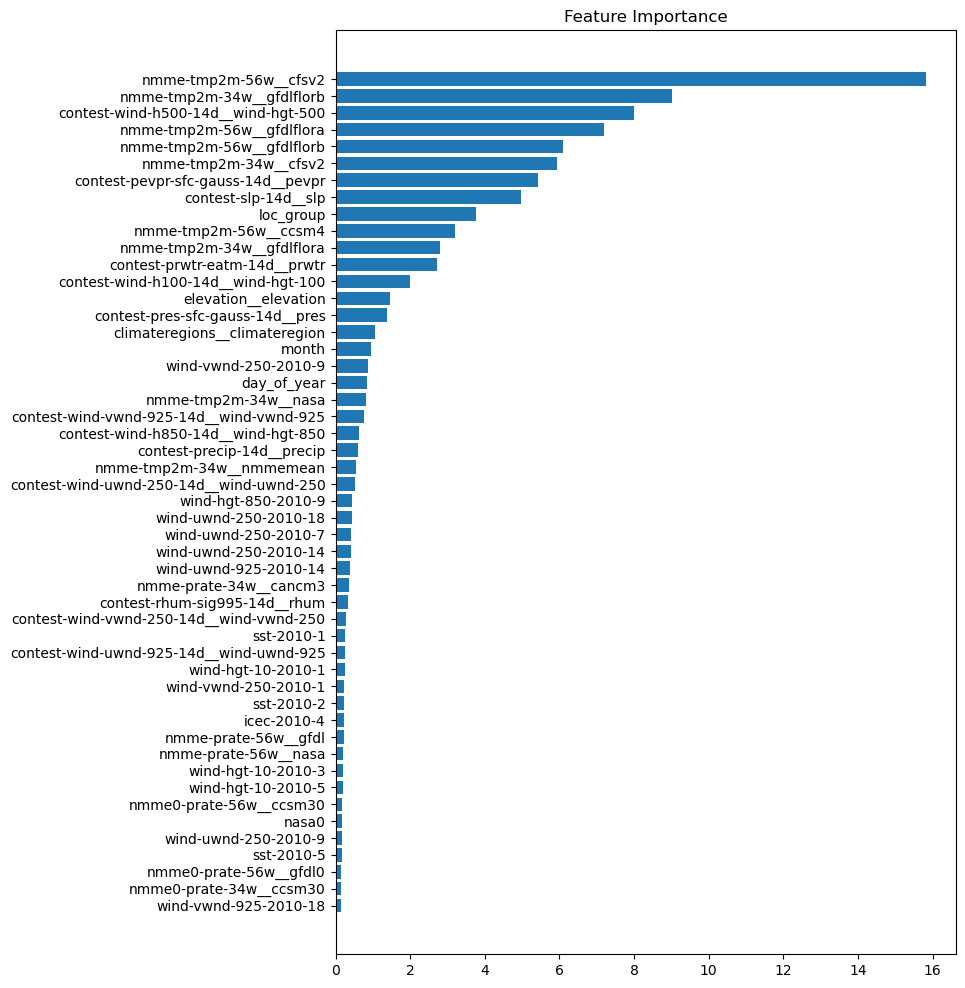

In [21]:
import matplotlib.pyplot as plt
feature_importance = model.feature_importances_
max_features = 50
sorted_idx = np.argsort(feature_importance)[-max_features:]
fig = plt.figure(figsize=(8, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X_val.columns)[sorted_idx])
plt.title('Feature Importance')

Original sample:
...

## Submit

In [22]:
submit = pd.read_csv("../../data/sample_solution.csv")
def generate_submission(model, name):
    submit[target] = model.predict(X_test)
    submit.to_csv(f'../../submissions/{name}.csv', index=False)

In [23]:
generate_submission(model, 'catboost0')